# Mitigating Unfairness in ML

In this lecture, we will explore various technical solutions for mitigating unfairness in ML.

## Installing the necessary libraries

In [69]:
!pip install pandas folktables requests scikit-learn tqdm

# Exercise 1: Risk scores and ROC Curves

As we discussed in the lecture, given inputs $\mathbf{x}$ and ground truth labels (y), we often train a risk predictor that gives us a score $f(\mathbf{x}) \in [0, 1]$. Here $y=1$ means high risk and $y=0$ means low risk.

Using this predictor, we binarize the decisions as $\hat{y} = f(\mathbf{x}) \geq t$. We select this threshold to minimize our loss. Often this loss takes the form $\ell(y, \hat{y}) = \mathbb{I}(y \neq \hat{y})$.

A more nuanced approach is to plot the ROC curve. The ROC curve is built as follows:

1. We vary our threshold $t$. Each value of $t$ will give us a different FPR and TPR. 
2. We plot a graph where the FPR is on x-axis and TPR is on the y-axis.

See for instance this example from [Wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic):


<img src="Roc_curve.svg.png" alt="drawing" style="width:500px;"/>

## 1a: Plotting the ROC curves [20 mins]

Use the COMPAS data code from below. Your task is:

1. Take the `decile_score` column. Plot the ROC curve where your risk score is the `decile_score`.
2. Print the threshold that leads to smallest possible 0-1 loss.

**Hint**: So far, we have assumed $f(\mathbf{x})$ to be between 0 and 1. The decile score, however, is between 1 and 10. If you want to use a threshold between 0 and 1, you can scale the decile score. Or you can just consider a threshold between 1 and 10. It would not make a difference on your final ROC curves or your loss.

In [3]:
from pathlib import Path

import matplotlib.style
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import requests
import folktables
from folktables import ACSDataSource, ACSEmployment


# Selecting the font size here will affect all the figures in this notebook
# Alternatively, you can set the font size for axis labels of each figure separately
font = {'size': 16}
matplotlib.rc('font', **font)

matplotlib.style.use("fivethirtyeight")

# Based on: https://fairlens.readthedocs.io/en/latest/user_guide/compas.html
url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
local_name = Path("compas-scores-two-years.csv")
if not local_name.is_file():
    response = requests.get(url)
    with open("compas-scores-two-years.csv", "w") as f:
        f.write(response.content.decode("utf-8"))
df = pd.read_csv(local_name)
df = df.sample(frac=1, random_state=1)

df = df[(df["days_b_screening_arrest"] <= 30)
        & (df["days_b_screening_arrest"] >= -30)
        & (df["is_recid"] != -1)
        & (df["c_charge_degree"] != 'O')
        & (df["score_text"] != 'N/A')].reset_index(drop=True)

In [17]:
df.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')

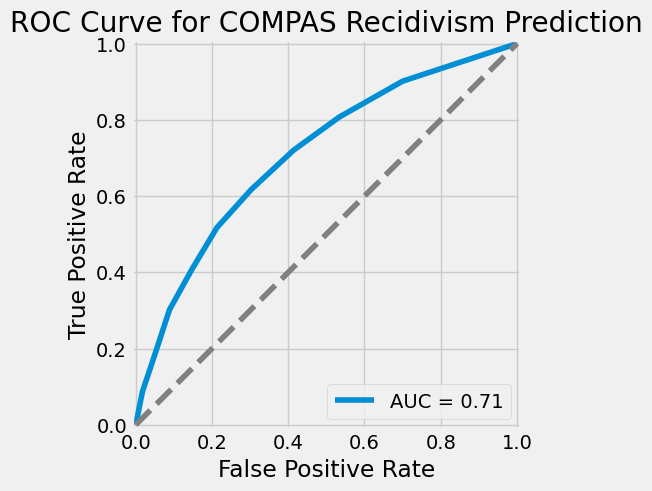

In [ ]:
# Your code here
y_true = df["two_year_recid"].values
y_scores = df["decile_score"].values

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay


fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = roc_auc_score(y_true, y_scores)
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
plt.title("ROC Curve for COMPAS Recidivism Prediction")
x = [0.0, 1.0]
y = [0.0, 1.0]
# get x and y at threshold

plt.plot(x, y, linestyle='--', color='gray')
plt.scatter()
plt.show()

Minimum loss: 0.3357096565132858 at threshold 6


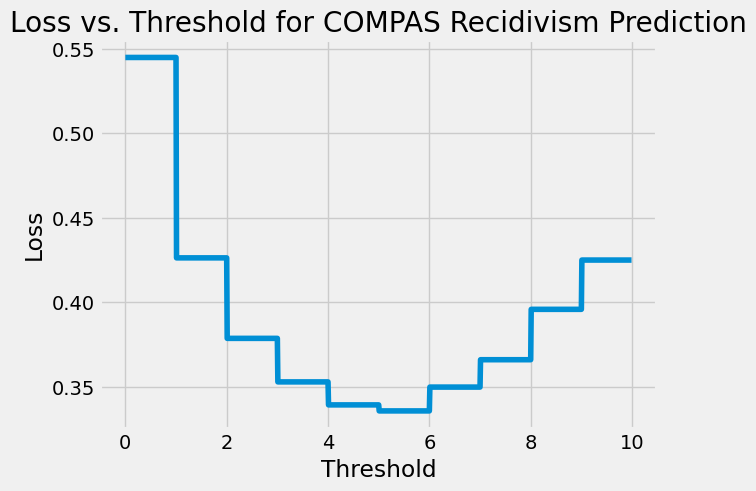

In [24]:
import math

def calculate_loss(y_true, y_scores, threshold):
    y_pred = np.array([1 if score >= threshold else 0 for score in y_scores])
    loss = np.sum(np.abs(y_true - y_pred)) / len(y_true)
    return loss

# print(list(set(y_scores)))
thresholds = np.arange(0.0, 10.0, 0.01)
losses = [calculate_loss(y_true, y_scores, threshold) for threshold in thresholds]
plt.plot(thresholds, losses)
plt.xlabel("Threshold")
plt.ylabel("Loss")
plt.title("Loss vs. Threshold for COMPAS Recidivism Prediction")    
print(f"Minimum loss: {min(losses)} at threshold {math.ceil(thresholds[np.argmin(losses)])}")
min_loss = min(losses)
threshold = math.ceil(thresholds[np.argmin(losses)])

## Exercise 1b: Group-specific ROC curves and thresholds [25 mins]

Plot the ROC AUC curves separately for the points with `race = African-American` and `race = Caucasian`.

Next, select a separate decision threshold for each group such that the difference in false positive rate between groups is less than 0.05. Of course, you should try to achieve these thresholds while minimizing the loss.

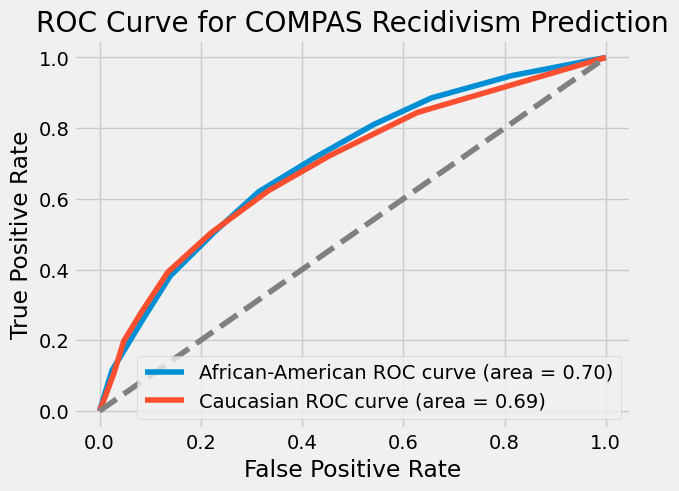

In [29]:
y_true_african_american = df[df["race"] == "African-American"]["two_year_recid"].values
y_scores_african_american = df[df["race"] == "African-American"]["decile_score"].values

y_true_cauc = df[df["race"] == "Caucasian"]["two_year_recid"].values
y_scores_cauc = df[df["race"] == "Caucasian"]["decile_score"].values

from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
african_american_fpr, african_american_tpr, african_american_thresholds = roc_curve(y_true_african_american, y_scores_african_american)
african_american_roc_auc = roc_auc_score(y_true_african_american, y_scores_african_american)
caucasian_fpr, caucasian_tpr, caucasian_thresholds = roc_curve(y_true_cauc, y_scores_cauc)
caucasian_roc_auc = roc_auc_score(y_true_cauc, y_scores_cauc)
plt.plot(african_american_fpr, african_american_tpr, label="African-American ROC curve (area = %0.2f)" % african_american_roc_auc)
plt.plot(caucasian_fpr, caucasian_tpr, label="Caucasian ROC curve (area = %0.2f)" % caucasian_roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for COMPAS Recidivism Prediction")
plt.legend(loc="lower right")
plt.show()


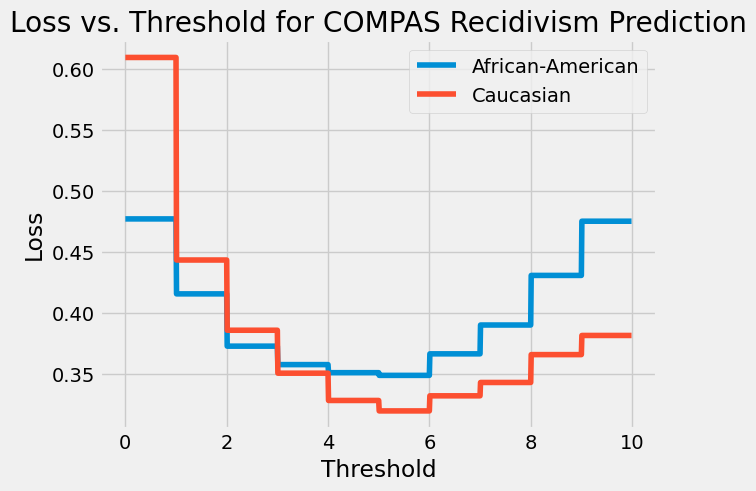

Minimum loss for African-American: 0.3486614173228346 at threshold 6
Minimum loss for Caucasian: 0.3195435092724679 at threshold 6


In [31]:
# Your code here.
# The threshold that minimizes the loss

thresholds_african_american = np.arange(0.0, 10.0, 0.01)
losses_african_american = [calculate_loss(y_true_african_american, y_scores_african_american, threshold) for threshold in thresholds_african_american]
min_threshold_african_american = math.ceil(thresholds_african_american[np.argmin(losses_african_american)])


thresholds_cauc = np.arange(0.0, 10.0, 0.01)
losses_cauc = [calculate_loss(y_true_cauc, y_scores_cauc, threshold) for threshold in thresholds_cauc]
min_threshold_cauc = math.ceil(thresholds_cauc[np.argmin(losses_cauc)])

plt.plot(thresholds_african_american, losses_african_american, label="African-American")
plt.plot(thresholds_cauc, losses_cauc, label="Caucasian")
plt.xlabel("Threshold")
plt.ylabel("Loss")
plt.title("Loss vs. Threshold for COMPAS Recidivism Prediction")
plt.legend()
plt.show()

print(f"Minimum loss for African-American: {min(losses_african_american)} at threshold {min_threshold_african_american}")
print(f"Minimum loss for Caucasian: {min(losses_cauc)} at threshold {min_threshold_cauc}")

In [58]:
def calculate_fpr(y_true, y_scores, threshold):
    if threshold is not None:
        y_pred = np.array([1 if score >= threshold else 0 for score in y_scores])
    else:
        y_pred = y_scores
    fp = np.sum((y_pred == 1) & (y_true == 0)) / np.sum(y_true == 0)
    return fp

cauc_pfr = calculate_fpr(y_true_cauc, y_scores_cauc, min_threshold_cauc)
african_american_pfr = calculate_fpr(y_true_african_american, y_scores_african_american, min_threshold_african_american)
print(f"False positive rate for Caucasian: {cauc_pfr} vs. African-American: {african_american_pfr}, difference: {abs(cauc_pfr - african_american_pfr)}")

False positive rate for Caucasian: 0.13505074160811867 vs. African-American: 0.3143989431968296, difference: 0.17934820158871093


In [41]:
def minimize_loss_with_fpr_difference(y_true_1, y_scores_1, y_true_2, y_scores_2, fpr_diff):
    thresholds_1 = np.sort(np.unique(y_scores_1))
    thresholds_2 = np.sort(np.unique(y_scores_2))
    best_thresholds_with_losses = None
    min_loss = float("inf")

    for threshold_1 in thresholds_1:
        for threshold_2 in thresholds_2:
            fpr_1 = calculate_fpr(y_true_1, y_scores_1, threshold_1)
            fpr_2 = calculate_fpr(y_true_2, y_scores_2, threshold_2)
            if abs(fpr_1 - fpr_2) <= fpr_diff:
                loss_1 = calculate_loss(y_true_1, y_scores_1, threshold_1)
                loss_2 = calculate_loss(y_true_2, y_scores_2, threshold_2)
                total_loss = loss_1 + loss_2
                if total_loss < min_loss:
                    min_loss = total_loss
                    best_thresholds_with_losses = (threshold_1, threshold_2, loss_1, loss_2)
    return best_thresholds_with_losses


threshold_1, threshold_2, min_loss_1, min_loss_2 = minimize_loss_with_fpr_difference(y_true_african_american, y_scores_african_american, y_true_cauc, y_scores_cauc, 0.05)
print(f"Threshold for African-American: {threshold_1}, Loss: {min_loss_1}")
print(f"Threshold for Caucasian: {threshold_2}, Loss: {min_loss_2}")

print(f"Difference in fpr: {abs(calculate_fpr(y_true_african_american, y_scores_african_american, threshold_1) - calculate_fpr(y_true_cauc, y_scores_cauc, threshold_2))}")


Threshold for African-American: 7, Loss: 0.3662992125984252
Threshold for Caucasian: 5, Loss: 0.3281027104136947
Difference in fpr: 0.007732668397068432


# Exercise 2: Training fair models [30 mins]

In the previous exercise, we took scores functions $f(\mathbf{x})$ that were already trained and tried to adjust the thresholds. In this exercise, we will try to train our score functions with fairness criteria in mind. 

Your task is to train a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model with different values of the regularization parameter $C$. Draw two plots, both with $C$ on x-axis. The first plot has the test set accuracy on y-axis. The second has the differences $FPR_{\text{African-American}} - FPR_{\text{caucasisn}} < \epsilon$ on the y-axis.

Next train different [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) models with various hyperparameter combinations. This time, the hyperparameters you can change are `n_estimators`, `criterion` and `max_depth`. What values of accuracy and FPR difference do you observe?

In [45]:
X = df[["age", "juv_fel_count", "juv_misd_count", "juv_other_count", "priors_count", "c_charge_degree"]]
X = pd.get_dummies(X, columns=["c_charge_degree"], drop_first=True)
y = df[["race", "two_year_recid"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

100%|██████████| 100/100 [00:02<00:00, 34.54it/s]


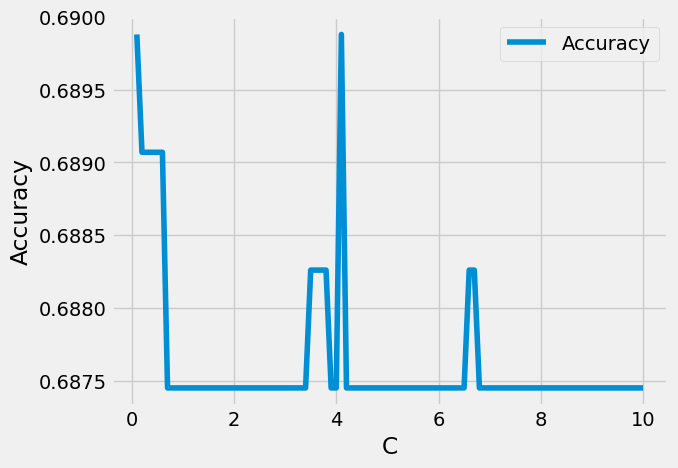

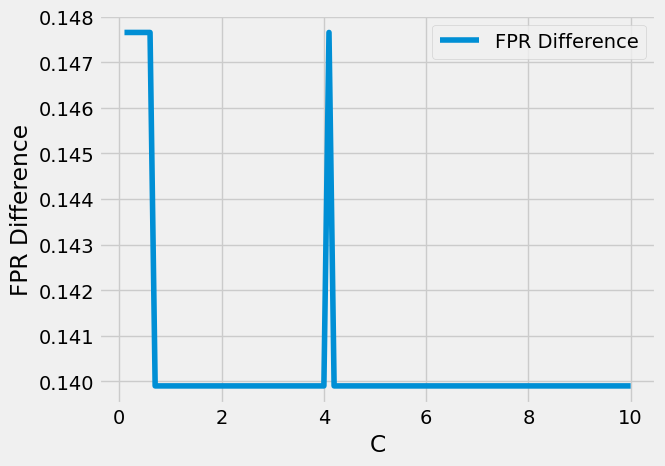

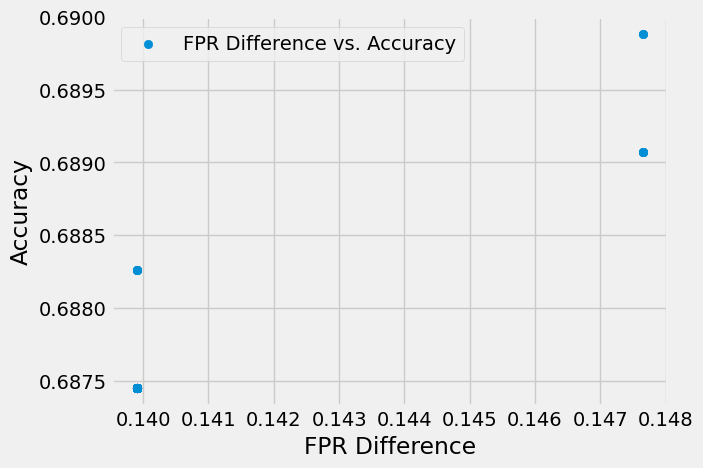

In [73]:
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

C = np.linspace(0.1, 10, 100)
models = [LogisticRegression(C=float(c)) for c in C]
acc = []
fpr_differences = []


for model in tqdm(models):
    y_train_new = y_train.copy()
    y_train_new = y_train_new["two_year_recid"]
    model.fit(X_train, y_train_new)
    y_test_all_races = y_test["two_year_recid"]
    acc.append(model.score(X_test, y_test_all_races))

    x_test_african_american = X_test[y_test["race"] == "African-American"]
    y_hat_african_american_scores = model.predict(x_test_african_american)
    
    x_test_cauc = X_test[y_test["race"] == "Caucasian"]
    y_hat_cauc_scores = model.predict(x_test_cauc)

    y_test_african_american = y_test[y_test["race"] == "African-American"]["two_year_recid"]
    y_test_cauc = y_test[y_test["race"] == "Caucasian"]["two_year_recid"]

    fpr_aa = calculate_fpr(y_test_african_american, y_hat_african_american_scores, threshold=None)
    fpr_cauc = calculate_fpr(y_test_cauc, y_hat_cauc_scores, threshold=None)
    fpr_differences.append(abs(fpr_aa - fpr_cauc).mean())
plt.plot(C, acc, label="Accuracy")
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.show()

plt.plot(C, fpr_differences, label="FPR Difference")
plt.legend()
plt.xlabel("C")
plt.ylabel("FPR Difference")
plt.show()

plt.scatter(fpr_differences, acc, label="FPR Difference vs. Accuracy")
plt.legend()
plt.xlabel("FPR Difference")
plt.ylabel("Accuracy")
plt.show()
    


        



100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


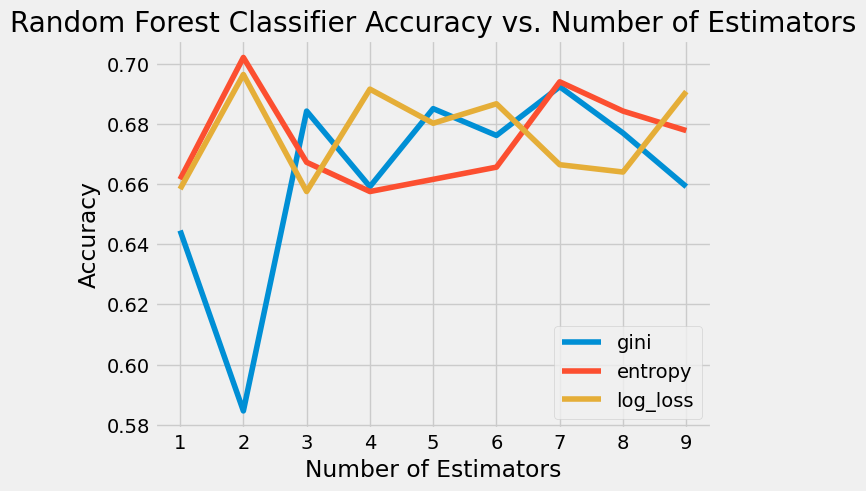

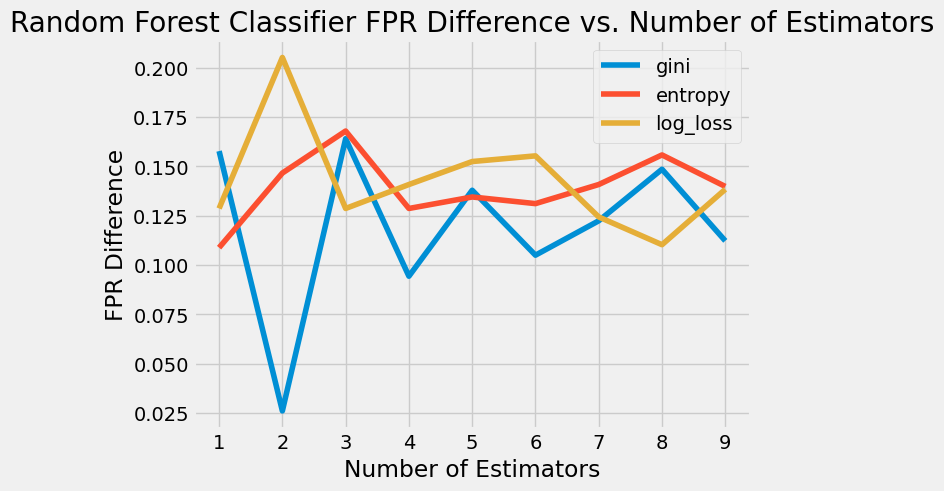

In [75]:
from sklearn.ensemble import RandomForestClassifier 
from tqdm import tqdm

n_estimators = np.arange(1, 10, 1)
criterion = ["gini", "entropy", "log_loss"] 

models = {c: [RandomForestClassifier(n_estimators=int(n), criterion=c, max_depth=3) for n in n_estimators] for c in criterion}
acc = {c: [] for c in criterion}
fpr_differences = {c: [] for c in criterion}
for (c, models) in tqdm(models.items()):
    for model in tqdm(models):
        y_train_new = y_train.copy()
        y_train_new = y_train_new["two_year_recid"]
        model.fit(X_train, y_train_new)
        y_test_all_races = y_test["two_year_recid"]
        acc[c].append(model.score(X_test, y_test_all_races))

        x_test_african_american = X_test[y_test["race"] == "African-American"]
        y_hat_african_american_scores = model.predict(x_test_african_american)
        
        x_test_cauc = X_test[y_test["race"] == "Caucasian"]
        y_hat_cauc_scores = model.predict(x_test_cauc)

        y_test_african_american = y_test[y_test["race"] == "African-American"]["two_year_recid"]
        y_test_cauc = y_test[y_test["race"] == "Caucasian"]["two_year_recid"]

        fpr_aa = calculate_fpr(y_test_african_american, y_hat_african_american_scores, threshold=None)
        fpr_cauc = calculate_fpr(y_test_cauc, y_hat_cauc_scores, threshold=None)
        fpr_differences[c].append(abs(fpr_aa - fpr_cauc).mean())

for c, acc_ in acc.items():
    plt.plot(n_estimators, acc_, label=c)
plt.legend()
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.title("Random Forest Classifier Accuracy vs. Number of Estimators")
plt.show()
for c, fpr_diff in fpr_differences.items():
    plt.plot(n_estimators, fpr_diff, label=c)
plt.legend()
plt.xlabel("Number of Estimators")
plt.ylabel("FPR Difference")
plt.title("Random Forest Classifier FPR Difference vs. Number of Estimators")
plt.show()



        

